In [1]:
import pandas as pd #1.2.2
import numpy as np #1.21.5
import IPython #7.31.1
from sklearn.model_selection import train_test_split #0.0
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
import torch #1.11.0
from torch import nn
from d2l import torch as d2l #0.17.3
import torchvision #0.12.0

C:\Users\msba7028gpu\anaconda3\envs\d2l\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\msba7028gpu\anaconda3\envs\d2l\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


### VGG

In [9]:
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    normalize])

In [10]:
imgs = torchvision.datasets.ImageFolder('./Data/images_original', transform = augs)
indices = torch.randperm(len(imgs)).tolist()
n = len(imgs)
n_test = int(0.3*n)
train_set = torch.utils.data.Subset(imgs, indices[:-(n_test)])
test_set = torch.utils.data.Subset(imgs, indices[-(n_test):])

In [11]:
print(imgs.class_to_idx)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [12]:
def vgg_fine_tuning(net, learning_rate, batch_size=64, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(train_set,
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(test_set,
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name.split('.')[0] == 'features']
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.classifier.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

loss 1.124, train acc 0.610, test acc 0.662
135.1 examples/sec on [device(type='cuda', index=0)]


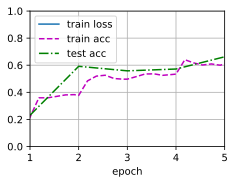

In [9]:
#pretrained vgg16, larger lr for fc than conv
finetune_vgg16 = torchvision.models.vgg16(pretrained=True)
finetune_vgg16.classifier[6] = nn.Linear(4096, 10, bias = True)
nn.init.xavier_uniform_(finetune_vgg16.classifier[0].weight)
nn.init.xavier_uniform_(finetune_vgg16.classifier[3].weight)
nn.init.xavier_uniform_(finetune_vgg16.classifier[6].weight)
vgg_fine_tuning(finetune_vgg16, 1e-4, batch_size = 32, param_group = True)

loss 1.442, train acc 0.484, test acc 0.619
448.1 examples/sec on [device(type='cuda', index=0)]


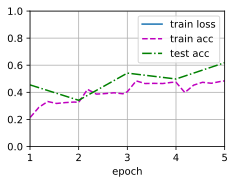

In [18]:
#pretrained vgg16, conv frozen
finetune_vgg16 = torchvision.models.vgg16(pretrained=True)
for param in finetune_vgg16.features.parameters():
    param.requires_grad = False #freeze all parameters
finetune_vgg16.classifier[6] = nn.Linear(4096, 10, bias = True)
nn.init.xavier_uniform_(finetune_vgg16.classifier[0].weight)
nn.init.xavier_uniform_(finetune_vgg16.classifier[3].weight)
nn.init.xavier_uniform_(finetune_vgg16.classifier[6].weight)
vgg_fine_tuning(finetune_vgg16, 1e-4, param_group = False)

loss 0.966, train acc 0.677, test acc 0.642
117.6 examples/sec on [device(type='cuda', index=0)]


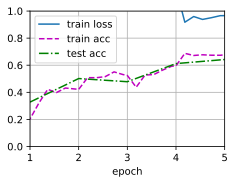

In [8]:
#pretrained vgg16_bn, larger lr for fc
finetune_vgg16bn = torchvision.models.vgg16_bn(pretrained=True)
finetune_vgg16bn.classifier[6] = nn.Linear(4096, 10, bias = True)
nn.init.xavier_uniform_(finetune_vgg16bn.classifier[0].weight)
nn.init.xavier_uniform_(finetune_vgg16bn.classifier[3].weight)
nn.init.xavier_uniform_(finetune_vgg16bn.classifier[6].weight)
vgg_fine_tuning(finetune_vgg16bn, 5e-5, param_group = True)

loss 1.651, train acc 0.451, test acc 0.368
1.4 examples/sec on [device(type='cpu')]


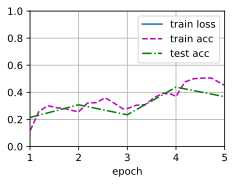

In [13]:
#pretrained vgg19, larger lr for fc
finetune_vgg19 = torchvision.models.vgg19(pretrained=True)
finetune_vgg19.classifier[6] = nn.Linear(4096, 10, bias = True)
nn.init.xavier_uniform_(finetune_vgg19.classifier[0].weight)
nn.init.xavier_uniform_(finetune_vgg19.classifier[3].weight)
nn.init.xavier_uniform_(finetune_vgg19.classifier[6].weight)
vgg_fine_tuning(finetune_vgg19, 1e-4, param_group = True)

loss 1.523, train acc 0.481, test acc 0.482
4.4 examples/sec on [device(type='cpu')]


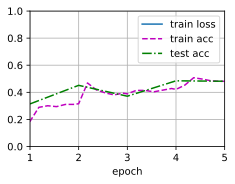

In [7]:
#pretrained vgg19, conv frozen
finetune_vgg19 = torchvision.models.vgg19(pretrained=True)
for param in finetune_vgg19.features.parameters():
    param.requires_grad = False #freeze all parameters
finetune_vgg19.classifier[6] = nn.Linear(4096, 10, bias = True)
nn.init.xavier_uniform_(finetune_vgg19.classifier[0].weight)
nn.init.xavier_uniform_(finetune_vgg19.classifier[3].weight)
nn.init.xavier_uniform_(finetune_vgg19.classifier[6].weight)
vgg_fine_tuning(finetune_vgg19, 5e-4, param_group = False)

### Inception

In [3]:
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(299),
    torchvision.transforms.ToTensor(),
    normalize])

In [4]:
imgs = torchvision.datasets.ImageFolder('./Data/images_original', transform = augs)
indices = torch.randperm(len(imgs)).tolist()
n = len(imgs)
n_test = int(0.3*n)
train = torch.utils.data.Subset(imgs, indices[:-(n_test)])
val= torch.utils.data.Subset(imgs, indices[-(n_test):])
datasets = {'train': train, 'val':val}

In [5]:
import time
import copy
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5, is_inception=False):
    since = time.time()
    device = 'cpu'
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1,num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.sum().backward()
                        optimizer.step()

                # statistics
                running_loss += (sum(loss.tolist())/len(loss.tolist())) * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [6]:
def inception_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    '''train_iter = torch.utils.data.DataLoader(train_set,
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(test_set,
        batch_size=batch_size)'''
    dataloaders_dict = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) 
                        for x in ['train', 'val']}
    device = torch.device('cpu')
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    model_ft, hist = train_model(net, dataloaders_dict, 
                                 loss, trainer, num_epochs=num_epochs, is_inception=True)

In [14]:
#pretrained inceptionV3
finetune_inception3 = torchvision.models.inception_v3(pretrained=True)
finetune_inception3.AuxLogits.fc = nn.Linear(finetune_inception3.AuxLogits.fc.in_features, 10)
finetune_inception3.fc = nn.Linear(finetune_inception3.fc.in_features, 10)
nn.init.xavier_uniform_(finetune_inception3.AuxLogits.fc.weight)
nn.init.xavier_uniform_(finetune_inception3.fc.weight)
inception_fine_tuning(finetune_inception3, 1e-4, param_group=True)

Epoch 1/5
----------
train Loss: 3.8245 Acc: 0.1171
val Loss: 2.8738 Acc: 0.1438

Epoch 2/5
----------
train Loss: 3.0034 Acc: 0.2871
val Loss: 1.9120 Acc: 0.2977

Epoch 3/5
----------
train Loss: 2.1929 Acc: 0.4171
val Loss: 1.6886 Acc: 0.4281

Epoch 4/5
----------
train Loss: 1.9023 Acc: 0.5029
val Loss: 1.3282 Acc: 0.5351

Epoch 5/5
----------
train Loss: 1.4568 Acc: 0.6014
val Loss: 1.2011 Acc: 0.5686

Training complete in 84m 20s
Best val Acc: 0.568562
